In [1]:
import pandas as pd
pd.set_option('display.max_columns', 300)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier
import xgboost as xgb

In [2]:
from matplotlib import style
style.use('seaborn')
%matplotlib inline

In [3]:
df=pd.read_csv('./Kickstarter_data/Kickstarter.csv',index_col='id')
df.head()

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1655941487,76,Dave-Man. A game about getting Dave his coffee.,"{""id"":35,""name"":""Video Games"",""slug"":""games/vi...",697,US,the United States,1541608918,"{""id"":294143625,""name"":""Lou Bagel"",""is_registe...",USD,$,True,USD,1556654150,False,NaN,1.0,150.0,NaN,False,NaN,1554062150,"{""id"":2379574,""name"":""Chicago"",""slug"":""chicago...",Dave-Man: Get Dave his Coffee,NaN,"{""key"":""assets/023/730/601/26b6ae17220668181ce...",697.0,"{""id"":3509432,""project_id"":3509432,""state"":""ac...",dave-man-get-dave-his-coffee,https://www.kickstarter.com/discover/categorie...,True,False,successful,1556654150,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",697.0,domestic
359915455,6,"My Vision ""Shanghai Dreaming Podcast""this seri...","{""id"":41,""name"":""Jazz"",""slug"":""music/jazz"",""po...",440,US,the United States,1377505616,"{""id"":1097916022,""name"":""Sabrina Montgomery"",...",USD,$,True,USD,1382136005,False,NaN,1.0,50000.0,NaN,False,NaN,1378248005,"{""id"":2453369,""name"":""Montgomery"",""slug"":""mont...","Shanghai Dreaming Podcast Short Stories, Music...",NaN,"{""key"":""assets/011/568/787/0ffceb99352d65b6121...",440.0,"{""id"":677027,""project_id"":677027,""state"":""inac...",shanghai-dreaming-podcast-short-stories-music-and,https://www.kickstarter.com/discover/categorie...,False,False,failed,1382136006,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",440.0,domestic
1859434546,2,I have always loved cookies and have a great r...,"{""id"":313,""name"":""Small Batch"",""slug"":""food/sm...",40,US,the United States,1424288631,"{""id"":1496002217,""name"":""daniel koert"",""is_reg...",USD,$,True,USD,1426952928,False,NaN,1.0,50000.0,NaN,False,NaN,1424364528,"{""id"":2438647,""name"":""Levittown"",""slug"":""levit...",Cookie Company,NaN,"{""key"":""assets/012/041/603/93cd2709b69338b14ca...",40.0,"{""id"":1714661,""project_id"":1714661,""state"":""in...",cookie-company,https://www.kickstarter.com/discover/categorie...,False,False,failed,1426952931,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",40.0,domestic
1279967793,73,Kickstarter Campaign for the The Art of Mitch ...,"{""id"":45,""name"":""Art Books"",""slug"":""publishing...",11192,US,the United States,1463615618,"{""id"":999214729,""name"":""Mitch Foust"",""is_regis...",USD,$,True,USD,1468202400,False,NaN,1.0,5000.0,NaN,False,NaN,1465560041,"{""id"":2449323,""name"":""Memphis"",""slug"":""memphis...",The Art of Mitch Foust 2016 Yearbook,NaN,"{""key"":""assets/011/250/029/4639aeccc8840194187...",11192.0,"{""id"":2522024,""project_id"":2522024,""state"":""in...",the-art-of-mitch-foust-2016-yearbook,https://www.kickstarter.com/discover/categorie...,True,False,successful,1468202400,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",11192.0,domestic
1340461995,0,"I want to make this an app that, 33 states and...","{""id"":51,""name"":""Software"",""slug"":""technology/...",0,US,the United States,1508774685,"{""id"":1461334453,""name"":""Sylvester S. Harris I...",USD,$,True,USD,1511458247,False,NaN,1.0,50000.0,NaN,False,NaN,1508862647,"{""id"":2441472,""name"":""Long Beach"",""slug"":""long...",Data Aggregator - Patent pending,NaN,"{""key"":""assets/018/879/453/26b51d9aa201e06e822...",0.0,"{""id"":3193987,""project_id"":3193987,""state"":""in...",data-aggregator-patent-pending,https://www.kickstarter.com/discover/categorie...,False,False,failed,1511458248,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",0.0,domestic


In [37]:
df.shape

(3706, 37)

In [60]:
df.state.unique()

array(['successful', 'failed', 'live', 'canceled'], dtype=object)

In [4]:
# Load in and concat all csv files for each month to first dataframe, starting from most recent to earliest
total_rows=df.shape[0]
total_unique=len(df.index.unique())
for num in range(1,56):
    if num<10:
        test_df=pd.read_csv('./Kickstarter_data/Kickstarter00{}.csv'.format(num), index_col='id')
        rows,unique=test_df.shape[0],len(test_df.index.unique())
        df=pd.concat([df,test_df])
       # print('{}: NumRows:'.format(num)+str(test_df.shape[0])+' vs NumUniqueIDs:'+str(len(test_df.index.unique())))
        total_rows+=rows
        total_unique+=unique
    else:
        test_df=pd.read_csv('./Kickstarter_data/Kickstarter0{}.csv'.format(num), index_col='id')
        rows,unique=test_df.shape[0],len(test_df.index.unique())
        df=pd.concat([df,test_df])
        #print('{}: NumRows:'.format(num)+str(test_df.shape[0])+' vs NumUniqueIDs:'+str(len(test_df.index.unique())))
        total_rows+=rows
        total_unique+=unique
        
print('Total Rows:'+str(total_rows)+', Total Unique:'+str(total_unique))

Total Rows:204625, Total Unique:204241


In [5]:
# create df with no dupes
df_nondupe=df[~df.index.duplicated(keep='first')]

In [6]:
# filter out campaigns that were canceled or are still live since they can't help train model to predict success/failure
df_train=df_nondupe[(df_nondupe.state=='successful') | (df_nondupe.state=='failed')]
df_train.state.unique()

array(['successful', 'failed'], dtype=object)

In [7]:
df_train.shape

(169626, 37)

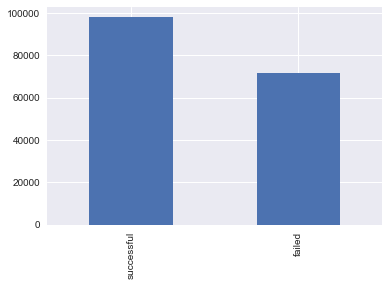

In [8]:
y=df_train.state
y.value_counts().plot(kind='bar')
plt.savefig('./visualizations/Class_Balance.png', dpi=300, bbox_inches='tight')

In [9]:
df_train['state']=np.where(df_train['state']=='successful',1,0)

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [334]:
df_train.state.mean()

0.5771874594696568

In [11]:
# Testing how to convert the unix time in df to UTC datetime
from datetime import datetime
test_unix=df_train.head(1).launched_at.values[0]

# if you encounter a "year is out of range" error the timestamp
# may be in milliseconds, try `ts /= 1000` in that case
type(datetime.utcfromtimestamp(test_unix).strftime('%Y-%m-%d '))

str

In [12]:
# Convert launch and end dates from unix/posix time to UTC time for all campaigns
df_train['date_launched']= df_train.launched_at.apply(datetime.utcfromtimestamp)
df_train['date_ending']= df_train.deadline.apply(datetime.utcfromtimestamp)
df_train[['date_launched','date_ending']].head()

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date_launched,date_ending
id,,
1655941487,2019-03-31 19:55:50,2019-04-30 19:55:50
359915455,2013-09-03 22:40:05,2013-10-18 22:40:05
1859434546,2015-02-19 16:48:48,2015-03-21 15:48:48
1279967793,2016-06-10 12:00:41,2016-07-11 02:00:00
1340461995,2017-10-24 16:30:47,2017-11-23 17:30:47


In [13]:
# parts=['year','month','day']
# for part in parts:
df_train['launch_year']=pd.DatetimeIndex(df_train.date_launched).year
df_train['end_year']=pd.DatetimeIndex(df_train.date_ending).year

df_train['launch_month']=pd.DatetimeIndex(df_train.date_launched).month
df_train['end_month']=pd.DatetimeIndex(df_train.date_ending).month

df_train['launch_day']=pd.DatetimeIndex(df_train.date_launched).day
df_train['end_day']=pd.DatetimeIndex(df_train.date_ending).day

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [14]:
# Make column to determine length of campaign in days
df_train['length']=(df_train.date_ending-df_train.date_launched).apply(lambda x: x.days)

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Convert dictionary in string to dictionary
df_train['category']=df_train['category'].apply(lambda x: ast.literal_eval(x))
#df_train['category'].unique()[0]

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TypeError: unhashable type: 'dict'

In [16]:

# Extract name of subcategory and parent category from dictionary in category column
df_train['subcategory_name']=df_train.category.apply(lambda x: x['name'])
df_train['category_name']=df_train.category.apply(lambda x: x['parent_name'] if 'parent_name'in x.keys() else x['name'])
df_train[['category_name','subcategory_name']].head()

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,category_name,subcategory_name
id,,
1655941487,Games,Video Games
359915455,Music,Jazz
1859434546,Food,Small Batch
1279967793,Publishing,Art Books
1340461995,Technology,Software


In [134]:
print(len(df_train.category_name.unique()))
print(len(df_train.subcategory_name.unique()))

15
159


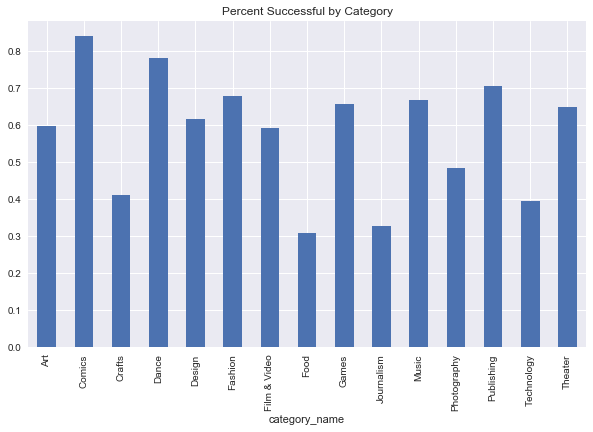

In [17]:
df_train.groupby('category_name')['state'].mean().plot(kind='bar', figsize=(10,6),title='Percent Successful by Category')

plt.savefig('./visualizations/Category_Success.png', dpi=300, bbox_inches='tight')

In [18]:
# Replace null values in blurb column with empty string
df_train.blurb.fillna('',inplace=True)
# Make column showing how many words were in each blurb
df_train['blurb_words']=df_train.blurb.apply(lambda x: len(x.split()))
df_train.blurb_words.head()

C:\Users\Drago\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


id
1655941487     8
359915455     22
1859434546    21
1279967793    18
1340461995    25
Name: blurb_words, dtype: int64

In [19]:
# Convert all Goal amounts to USD to standardize them
df_train['goal']=np.where(df_train.currency!='USD',df_train.goal*df_train.static_usd_rate,df_train.goal)

C:\Users\Drago\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
df_train.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [222]:
df_train.isnull().mean()

backers_count               0.000000
blurb                       0.000000
category                    0.000000
converted_pledged_amount    0.000000
country                     0.000000
country_displayable_name    0.000000
created_at                  0.000000
creator                     0.000000
currency                    0.000000
currency_symbol             0.000000
currency_trailing_code      0.000000
current_currency            0.000000
deadline                    0.000000
disable_communication       0.000000
friends                     1.000000
fx_rate                     0.000000
goal                        0.000000
is_backing                  1.000000
is_starrable                0.000000
is_starred                  1.000000
launched_at                 0.000000
location                    0.001049
name                        0.000000
permissions                 1.000000
photo                       0.000000
pledged                     0.000000
profile                     0.000000
s

In [20]:
df_final=df_train.drop(columns=['creator','backers_count','category','converted_pledged_amount','country_displayable_name',
                                'currency_symbol','currency_trailing_code','current_currency','disable_communication','blurb',
                                'friends','fx_rate','is_backing','is_starrable','is_starred','location','name','permissions',
                                'photo','pledged','profile','slug','state_changed_at','static_usd_rate','urls','source_url',
                                'usd_pledged','usd_type','date_launched','date_ending'])

In [21]:
df_final.columns

Index(['country', 'created_at', 'currency', 'deadline', 'goal', 'launched_at',
       'spotlight', 'staff_pick', 'state', 'launch_year', 'end_year',
       'launch_month', 'end_month', 'launch_day', 'end_day', 'length',
       'subcategory_name', 'category_name', 'blurb_words'],
      dtype='object')

In [37]:
df_dummies=pd.get_dummies(df_final.drop(columns=['subcategory_name']), columns = ['country','currency','category_name'],drop_first=True)

In [38]:
df_dummies.columns

Index(['created_at', 'deadline', 'goal', 'staff_pick', 'state', 'launch_year',
       'launch_month', 'end_month', 'launch_day', 'end_day', 'length',
       'blurb_words', 'country_AU', 'country_BE', 'country_CA', 'country_CH',
       'country_DE', 'country_DK', 'country_ES', 'country_FR', 'country_GB',
       'country_HK', 'country_IE', 'country_IT', 'country_JP', 'country_LU',
       'country_MX', 'country_NL', 'country_NO', 'country_NZ', 'country_SE',
       'country_SG', 'country_US', 'currency_CAD', 'currency_CHF',
       'currency_DKK', 'currency_EUR', 'currency_GBP', 'currency_HKD',
       'currency_JPY', 'currency_MXN', 'currency_NOK', 'currency_NZD',
       'currency_SEK', 'currency_SGD', 'currency_USD', 'category_name_Comics',
       'category_name_Crafts', 'category_name_Dance', 'category_name_Design',
       'category_name_Fashion', 'category_name_Film & Video',
       'category_name_Food', 'category_name_Games', 'category_name_Journalism',
       'category_name_Music', 'ca

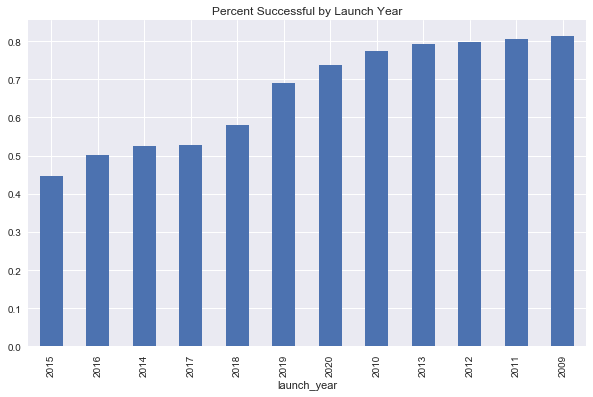

In [22]:
df_final.groupby('launch_year')['state'].mean().sort_values().plot(kind='bar', 
                                                                   figsize=(10,6),title='Percent Successful by Launch Year')

plt.savefig('./visualizations/LaunchYear_Success.png', dpi=300, bbox_inches='tight')

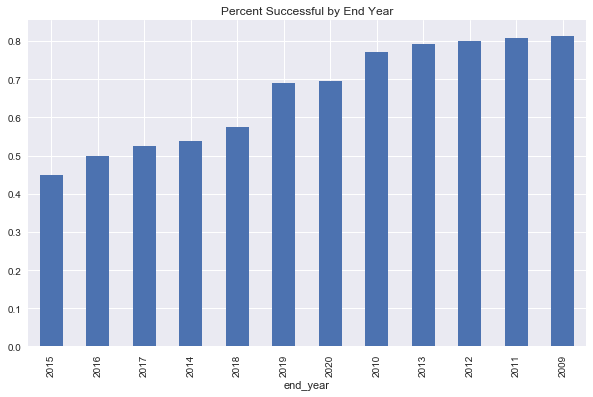

In [23]:
df_final.groupby('end_year')['state'].mean().sort_values().plot(kind='bar', 
                                                                   figsize=(10,6),title='Percent Successful by End Year')

plt.savefig('./visualizations/EndYear_Success.png', dpi=300, bbox_inches='tight')

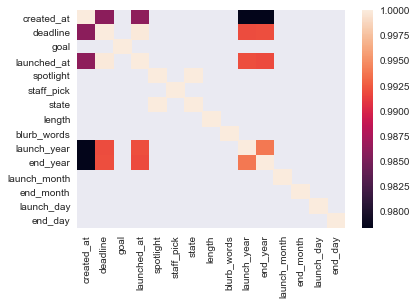

In [276]:
sns.heatmap(df_final.corr()[df_final.corr()>0.85])

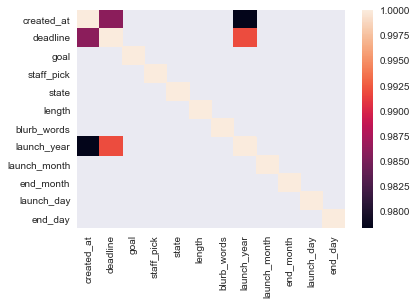

In [283]:
corr=df_final.drop(columns=['launched_at','end_year','spotlight']).corr()
sns.heatmap(corr[corr>0.85])

In [36]:
df_final.drop(columns=['launched_at','end_year','spotlight'],inplace=True)

In [294]:
df_final.groupby('length')['state'].mean().sort_values()#.plot.bar()

length
60    0.308435
59    0.354759
64    0.375000
85    0.400000
58    0.424184
        ...   
79    1.000000
77    1.000000
67    1.000000
82    1.000000
97    1.000000
Name: state, Length: 92, dtype: float64

In [297]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169626 entries, 1655941487 to 1731611971
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           169626 non-null  object 
 1   created_at        169626 non-null  int64  
 2   currency          169626 non-null  object 
 3   deadline          169626 non-null  int64  
 4   goal              169626 non-null  float64
 5   staff_pick        169626 non-null  bool   
 6   state             169626 non-null  int32  
 7   subcategory_name  169626 non-null  object 
 8   category_name     169626 non-null  object 
 9   length            169626 non-null  int64  
 10  blurb_words       169626 non-null  int64  
 11  launch_year       169626 non-null  int64  
 12  launch_month      169626 non-null  int64  
 13  end_month         169626 non-null  int64  
 14  launch_day        169626 non-null  int64  
 15  end_day           169626 non-null  int64  
dtypes: bool

In [42]:
y=df_final.state
X=df_final.drop(columns=['state'])

In [43]:
X_d=df_dummies.drop(columns=['state'])

In [295]:
#Train Test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23,stratify=y)

In [44]:
X_dtrain, X_dtest, y_train, y_test = train_test_split(X_d, y, random_state=23,stratify=y)

In [347]:
# Scaling data
scaler = StandardScaler()  
scaler.fit(X_dtrain)

X_scale_train = scaler.transform(X_dtrain)  
X_scale_test = scaler.transform(X_dtest)

## Random Forest

In [34]:
rfc=RandomForestClassifier(class_weight='balanced',random_state=17,max_depth=3)
rfc.fit(X_dtrain,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [35]:
y_pred=rfc.predict(X_dtest)

print('Accuracy:',accuracy_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

Accuracy: 0.9974060886174453
F1 Score: 0.9977569331158238


In [350]:
rfcs=RandomForestClassifier(class_weight='balanced',random_state=17,max_depth=3)
rfcs.fit(X_scale_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [351]:
y_pred_scale=rfcs.predict(X_scale_test)

print('Accuracy:',accuracy_score(y_test,y_pred_scale))
print('F1 Score:',f1_score(y_test,y_pred_scale))

Accuracy: 0.6992006036739218
F1 Score: 0.709747883862747


         Feature  Importance
29    country_SE    0.000000
42  currency_SEK    0.000000
41  currency_NZD    0.000000
38  currency_JPY    0.000000
34  currency_DKK    0.000000
20    country_HK    0.000000
27    country_NO    0.000000
30    country_SG    0.000000
18    country_FR    0.000000
17    country_ES    0.000000
23    country_JP    0.000000
14    country_CH    0.000000
16    country_DK    0.000000
40  currency_NOK    0.000067
43  currency_SGD    0.000326
13    country_CA    0.000579
12    country_BE    0.000633
28    country_NZ    0.000681
21    country_IE    0.000751
33  currency_CHF    0.001452


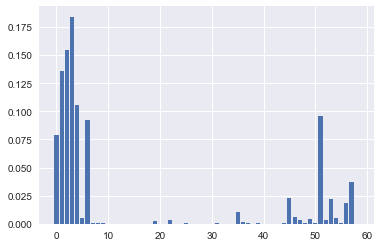

In [370]:
# get importance
importances = rfc.feature_importances_
# summarize feature importance
featureImp=[]
for feat, importance in zip(X_dtrain.columns, importances):  
    temp = [feat, importance*100]
    featureImp.append(temp)

rfc_importance = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
print (rfc_importance.sort_values('Importance').head(20))
# for i,v in enumerate(importances):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

In [328]:
importance=rfc.feature_importances_
importance

array([4.50102918e-02, 3.86229005e-02, 4.07789002e-02, 1.81393513e-01,
       6.53661100e-02, 1.14593994e-03, 7.31749471e-02, 5.97889284e-05,
       4.79813836e-05, 7.13448832e-05, 6.01640801e-05, 0.00000000e+00,
       9.20518721e-06, 5.48425254e-06, 1.52734535e-06, 3.67953446e-07,
       6.85005376e-06, 0.00000000e+00, 1.68395201e-06, 1.65714077e-07,
       2.14676209e-04, 1.88175218e-05, 3.72544969e-04, 7.12007493e-09,
       2.25369275e-06, 7.61768223e-05, 3.25974405e-05, 0.00000000e+00,
       0.00000000e+00, 7.52259742e-06, 0.00000000e+00, 3.77737292e-05,
       6.99378274e-06, 6.28216469e-07, 3.66657901e-06, 4.72205295e-03,
       1.17482580e-04, 3.02030923e-07, 4.54650381e-05, 5.90414932e-05,
       3.34506215e-06, 2.05798252e-06, 0.00000000e+00, 7.77922979e-07,
       3.53655940e-04, 6.94349828e-04, 2.33604532e-02, 0.00000000e+00,
       0.00000000e+00, 1.26123207e-05, 6.42662798e-06, 5.74761325e-03,
       5.05323452e-03, 1.74383238e-04, 1.45297446e-03, 2.18239729e-04,
      

## XGboost

In [45]:
xgb_test=xgb.XGBClassifier(objective ='binary:logistic')
xgb_test.fit(X_dtrain,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
y_pred_xgb=xgb_test.predict(X_dtest)

print('Accuracy:',accuracy_score(y_test,y_pred_xgb))
print('F1 Score:',f1_score(y_test,y_pred_xgb))

Accuracy: 0.7573985426934232
F1 Score: 0.7954590639786869


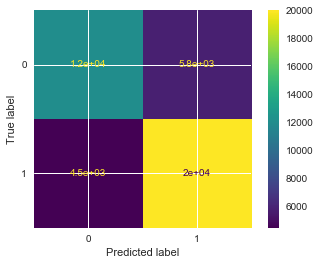

In [47]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_test,X_dtest,y_test)
plt.show()

In [355]:
print(metrics.classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.73      0.68      0.70     17930
           1       0.77      0.82      0.80     24477

    accuracy                           0.76     42407
   macro avg       0.75      0.75      0.75     42407
weighted avg       0.76      0.76      0.76     42407



In [356]:
xgb_tests=xgb.XGBClassifier(objective ='binary:logistic')
xgb_tests.fit(X_scale_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [357]:
y_pred_xgb_scale=xgb_tests.predict(X_scale_test)

print('Accuracy:',accuracy_score(y_test,y_pred_xgb_scale))
print('F1 Score:',f1_score(y_test,y_pred_xgb_scale))

Accuracy: 0.7575400287688353
F1 Score: 0.7962023309284072


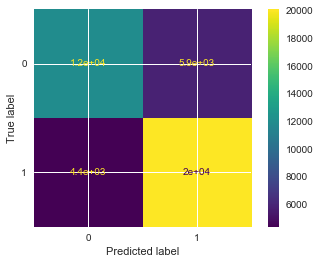

In [358]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_tests,X_scale_test,y_test)
plt.show()

In [359]:
print(metrics.classification_report(y_test,y_pred_xgb_scale))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70     17930
           1       0.77      0.82      0.80     24477

    accuracy                           0.76     42407
   macro avg       0.75      0.75      0.75     42407
weighted avg       0.76      0.76      0.76     42407



['country_NO' 'currency_CAD' 'currency_CHF' 'currency_DKK' 'currency_GBP'
 'currency_HKD' 'currency_JPY' 'currency_MXN' 'currency_NOK'
 'currency_NZD' 'currency_SEK' 'currency_SGD' 'currency_USD']


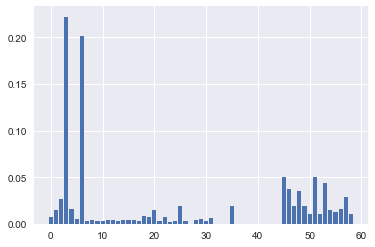

In [371]:
# get importance
importance_xgb = xgb_test.feature_importances_
featureImpx=[]
for feat, importance in zip(X_dtrain.columns, importance_xgb):  
    temp = [feat, importance*100]
    featureImpx.append(temp)
# summarize feature importance
# for i,v in enumerate(importance_xgb):
# 	print('Feature: %0d, Score: %.5f' % (i,v))

xgb_importance = pd.DataFrame(featureImpx, columns = ['Feature', 'Importance'])
imp_0=xgb_importance.Feature[xgb_importance.Importance==0].values
print(imp_0)
# plot feature importance
plt.bar([x for x in range(len(importance_xgb))], importance_xgb)
plt.show()

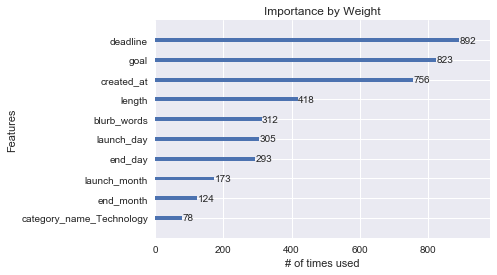

In [50]:
# Plot Top 10 important features by weight
xgb.plot_importance(xgb_test, max_num_features=10,title='Importance by Weight',xlabel='# of times used')

plt.savefig('./visualizations/XGB_Top_Features.png', dpi=300, bbox_inches='tight')

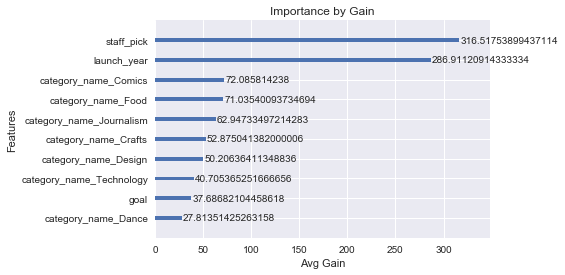

In [51]:
# Plot Top 10 important features by weight
xgb.plot_importance(xgb_test, max_num_features=10,importance_type='gain',title='Importance by Gain',xlabel='Avg Gain')

plt.savefig('./visualizations/XGB_Top_Gains.png', dpi=300, bbox_inches='tight')

## XGboost GridSearch

In [364]:
#Instantiate xgb model for gridsearch
xgb_base = xgb.XGBClassifier(objective = 'binary:logistic')
# Set up params
param_dict = {'n_estimators': [100,300,500],
              'learning_rate': [0.1,0.07,0.05],
              'subsample':[0.3,0.4],
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3],
              'scale_pos_weight':[1.0,1.38]
             }

In [365]:
# initiate the Gridsearch model
xgb_grid = GridSearchCV(
    estimator = xgb_base,
    param_grid = param_dict, 
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)


In [ ]:
xgb_grid.fit(X_dtrain.drop(columns=imp_0),y_train)

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 43.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 122.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 257.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 389.8min


In [233]:
df_train[(df_train.currency!=df_train.current_currency)&(df_train.state==0)][['converted_pledged_amount','country_displayable_name','currency',
                                                        'current_currency','fx_rate','goal','pledged','static_usd_rate',
                                                        'usd_pledged','state']]

,converted_pledged_amount,country_displayable_name,currency,current_currency,fx_rate,goal,pledged,static_usd_rate,usd_pledged,state
id,,,,,,,,,,
610974227,60,New Zealand,NZD,USD,0.607548,29471.122875,82.0,0.785897,64.443522,0
1426539402,1341,Switzerland,CHF,USD,1.040524,58146.249279,1328.0,1.004253,1333.647997,0
1427082994,2831,France,EUR,USD,1.097649,5655.315300,2570.0,1.131063,2906.832064,0
881336601,127,Hong Kong,HKD,USD,0.129000,12808.538000,1000.0,0.128085,128.085380,0
883745144,1276,Australia,AUD,USD,0.627763,25830.391650,1655.0,0.738011,1221.408519,0
...,...,...,...,...,...,...,...,...,...,...
1543404362,3,Mexico,MXN,USD,0.042649,985.087476,60.0,0.052398,3.143896,0
1266099862,14523,Hong Kong,HKD,USD,0.129021,25618.090000,113450.0,0.128090,14531.861553,0
1822859144,3354,Hong Kong,HKD,USD,0.129021,25550.778000,26190.0,0.127754,3345.874379,0


In [231]:
df_train[(df_train.pledged<df_train.goal)&(df_train.state==1)][['converted_pledged_amount','country_displayable_name','currency',
                                                        'current_currency','fx_rate','goal','pledged','static_usd_rate',
                                                        'usd_pledged','state']]

,converted_pledged_amount,country_displayable_name,currency,current_currency,fx_rate,goal,pledged,static_usd_rate,usd_pledged,state
id,,,,,,,,,,
1769772834,30716,the United States,USD,USD,1.0,36000.0,30716.0,1.0,30716.0,1


In [282]:
df_final.state[df_final.spotlight==False].unique()

array([0])